# Quake

### Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Creating a dataframe using Pandas named 'ds' & removing all Null Values in the Dataframe

In [ ]:
ds = pd.read_csv('database.csv')
ds.dropna(inplace=True)
print(ds)

### Creating a column named MMI (having 0 or 1 as value depending on the Magnitude)

In [ ]:
import numpy as np

# Function to map magnitude to MMI levels
def map_magnitude_to_mmi(magnitude):
    if magnitude < 0:
        return np.nan  # Exclude rows with negative magnitude
    elif magnitude < 3.0:
        return 0
    else:
        return 1

# Apply the mapping function to the 'mag' column and create a new column 'MMI'
ds['MMI'] = ds['mag'].map(map_magnitude_to_mmi)

# Drop rows with NaN values in the 'MMI' column
ds.dropna(subset=['MMI'], inplace=True)

# Print the updated dataframe
print(ds)


### Observing our Dataset (Location vs Earthquake Magnitude)

In [ ]:
import plotly.express as px

# Create a map of magnitudes
fig = px.scatter_mapbox(data_frame=ds, lat="latitude", lon="longitude", color="mag", zoom=0)

# Update the layout if needed
fig.update_layout(
    mapbox=dict(
        center=dict(lat=0, lon=0),
        style="open-street-map"
    ),
    width=800,
    height=600
)

# Save the figure as a PNG file
fig.write_image("magnitude_map.png")


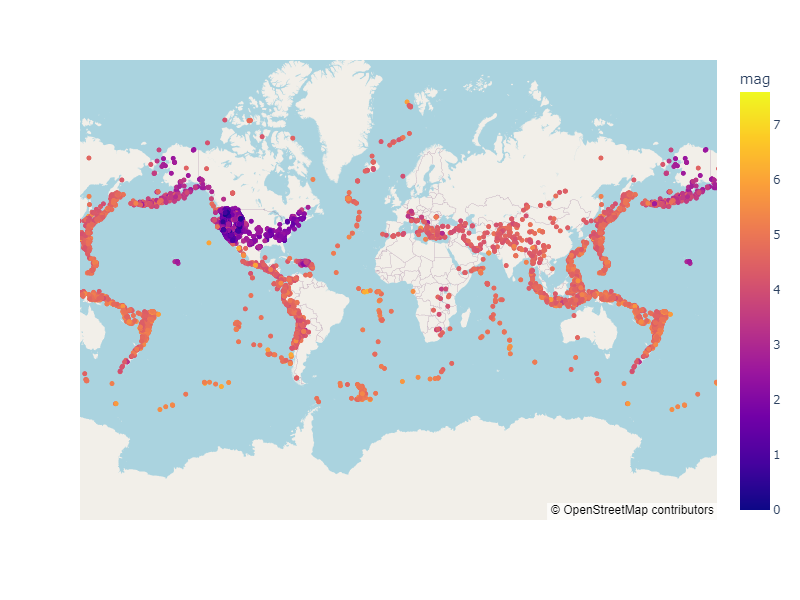

#### Taking the 5 Major Factors - Latitude, Longitude, Depth (Sea), Azimuthal Gap & Root Mean Square Value

In [ ]:
X = ds.iloc[:, 1:6].values
Y = ds.iloc[:,22].values
print(Y)

### Spliiting with the help of sklearn

In [ ]:
Xtr, Xtst, Ytr, Ytst = train_test_split(X, Y, test_size=0.2 )

#### Checking if the vlaues have been stored before training the model

In [ ]:
print(Xtr)

## Using Sequential Model with 2 layers of ReLu and 1 output layer of Sigmoid

In [ ]:
# define the keras model
model = Sequential()
model.add(Dense(32, input_dim=5, activation='relu'))
model.add(Dense(16, activation='relu'))
#model.add(Dense(102, activation='relu'))
#model.add(Dense(102, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 
print(type(model))

### Compiling using Binary Cross Entropy Loss Function (as output is in range of 0 and 1) and 10 epoch 

In [ ]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  

# fit the keras model on the dataset
model.fit(Xtr, Ytr, epochs=10, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(Xtst, Ytst, verbose=0)
print('Accuracy: %.2f ' % (accuracy*100))


### Predicting the model

In [ ]:
Yprd = model.predict(Xtst)
print(Yprd)

#### Check for one-hot encoded Format (not necessary, as already a non binary vector output. Converting into Int) 

In [ ]:
# Convert Ytst and Yprd to integer labels if one-hot encoded
if len(Ytst.shape) > 1 and Ytst.shape[1] > 1:
    Ytst = np.argmax(Ytst, axis=1)
    Yprd = np.argmax(Yprd, axis=1)
else:
    Ytst = Ytst.astype(int)

Yprd = Yprd.astype(int)  # Convert Yprd to integer type
print(Yprd, '\n\n\n')
print(confusion_matrix(Ytst, Yprd))
print('\n\n', classification_report(Ytst, Yprd))

#### Save Model

In [ ]:
#save model
model.save("/tmp/earthquake_model.h5")
print("Model saved.")

#### Load Model

In [ ]:
# Load the model
loaded_model = tf.keras.models.load_model("/tmp/earthquake_model.h5")
print("Model loaded.")

### Creating 2 Categories

In [ ]:
categories = ["No Earthquake", "Earthquake"]

## Check Accuracy Plot

In [ ]:
import matplotlib.pyplot as plt
# Plotting
plt.scatter(range(len(Ytst)), Ytst, label='Actual')
plt.scatter(range(len(Yprd)), Yprd, label='Predicted')
plt.xlabel('Data point')
plt.ylabel('Label')
plt.legend()
plt.show()

## Web Application

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from flask import Flask, render_template, request

# Define the Flask app
app = Flask(__name__)
ds = pd.read_csv('database.csv')
ds.dropna(inplace=True)

# Home page
@app.route('/')
def index():
    return render_template('indexNew.html', ds=ds.to_dict('records'))

# Predict route
@app.route('/detect', methods=['POST'])
def detect():
    lat = float(request.form['lat'])
    long = float(request.form['long'])
    depth = float(request.form['depth'])
    azu = float(request.form['azu'])
    rms = float(request.form['rms'])

    # Predict
    inp = np.asarray([[lat, long, depth, azu, rms]], dtype=np.float32)
    predict = model.predict(inp)
    preq = predict[0][0]
    if preq >= 0.5 and preq < 1:
        preq = int(preq) + 1
    else:
        preq = int(preq)
    result = categories[preq]
    return render_template('detect.html', lat=lat, long=long, depth=depth, rms=rms, azu=azu, result=result)

# Helpline page
@app.route('/helpline')
def helpline():
    return render_template('helpline.html')

if __name__ == '__main__':
    app.run()
